In [1]:
%load_ext autoreload
# from ggplot import *
%autoreload 2
import itertools
from scipy import stats
from util import *
from joblib import Parallel, delayed
import time
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline
import matplotlib.style
import matplotlib as mpl
from cycler import cycler
from fancyimpute import KNN
# plt.rcParams['axes.facecolor'] = 'white'

mpl.rcParams['grid.color'] = 'y'
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

In [54]:
def get_label_from_dbscan(df, eps=0.2, min_samples=3, outlier=True):

    df = df.fillna(-1)
    outlier=True

    date = df.index
    df['INDEX'] = np.arange(3, len(df.STOCK_AMOUNT) + 3)
    Z = df[['STOCK_AMOUNT', 'INDEX']].values
    Z = np.vstack((Z, [[0, 2], [500, 1]]))

    scaler = preprocessing.MinMaxScaler(feature_range=(0, 100))
    Z[:, 0] = scaler.fit_transform(Z[:, 0].reshape(-1, 1))[:, 0]
    X = StandardScaler().fit_transform(Z)
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    return (n_clusters_, labels[:-2])

In [55]:
def get_feature_engineered_bundle(df):
    
    def get_arr_in_cluster(df):

        empty_lst = []
        for name, group in df.groupby('label')['STOCK_AMOUNT']:
            result_lst = np.sort(np.diff(group))[1:-1]
            empty_lst = np.append(empty_lst, result_lst)
        arr_in_cluster = -empty_lst[empty_lst < 0]
        return arr_in_cluster
    
    # The number of unique stock_id

    df = df.set_index("REG_DT")
    unique_stock_ids = df.STOCK_ID.unique()
    n_unique_stock_id = len(unique_stock_ids) 
    
    # select a single stock_id
    tmp2 = list(df.groupby('STOCK_ID'))[0][1]
    
    
    
    # The ratio of NA
    tmp3 = tmp2.resample('1D').first()
    
    # The number of days
    n_days = len(tmp3.ID)
    
    if n_days <=1:
        return
    
    null_arr = pd.isnull(tmp3.ID).values
    ratio_of_na = sum(null_arr) / float(n_days)
    
    
    consecutive_lst = [ sum( 1 for _ in group ) for key, group in itertools.groupby( null_arr ) if key ]
    
    
    # The max value of consecutive NAs 
    max_consecutive_na = max([0] + consecutive_lst)
    

    # The instances of consecutive NAs
    n_consecutive_na = len(consecutive_lst)
    
    # Define a stock array
    stock_arr = tmp3.STOCK_AMOUNT.values
    
    # The medain
    median_v = np.nanmedian(stock_arr)
    
    # Std
    std_v = np.nanstd(stock_arr)
    
    # max, min
    max_v = np.nanmax(stock_arr)
    min_v = np.nanmin(stock_arr)
    
    # The range between max and min
    range_v = max_v - min_v
    
    stock_na_removed = stock_arr[~np.isnan(stock_arr)]
    
    consecutive_same_lst = [ sum( 1 for _ in group ) for key, group in itertools.groupby( stock_na_removed ) if key ]
    
    if len(consecutive_same_lst) == 0:
        ratio_same_value = 0
    else:
        ratio_same_value = max(consecutive_same_lst) / float(n_days)
    
    
    n_jumps = sum(np.diff(stock_na_removed) > 0)
    max_drop = -min(np.diff(stock_na_removed))
    
    tmp3['STOCK_AMOUNT'] = tmp3.STOCK_AMOUNT.replace(np.nan, -1)
    n_cluster, label = get_label_from_dbscan(tmp3)
    
    tmp3['label'] = label
    arr_in_cluster = get_arr_in_cluster(tmp3)
    
    mean_in_cluster = np.nanmean(arr_in_cluster)
    std_in_cluster = np.nanstd(arr_in_cluster)
    

    
    bundle = {
        'item_id': df.ITEM_ID.values[0],
        'stock_id': tmp3.STOCK_ID.values[0],
        'n_unique_stock_id': n_unique_stock_id,
        'n_days': n_days,
        'ratio_of_na': ratio_of_na,
        'max_consecutive_na': max_consecutive_na,
        'n_consecutive_na': n_consecutive_na,
        'median_v': median_v,
        'std_v': std_v,
        'max_v': max_v,
        'ratio_drop': max_drop / float(max_v),
        'min_v': min_v,
        'range_v': range_v,
        'ratio_same_value': ratio_same_value,
        'n_jumps': n_jumps,
        'max_drop': max_drop,
        'n_cluster': n_cluster,
        'mean_in_cluster': mean_in_cluster,
        'std_in_cluster': std_in_cluster

    }
    
    return bundle

In [4]:
def get_ivt_item(item_id):
    result = list(data_dict[item_id].groupby('STOCK_ID'))[0][1]
    return result


In [263]:
def map_clean_up_target_df(series):

    tmp_df = pd.DataFrame(series)
    tmp_df.columns = ['STOCK_AMOUNT']
    tmp_df['REG_DT'] = tmp_df.index
    return clean_up_target_df(tmp_df)['sell_impute']

In [264]:
def get_sell_amount_by_item_id(df):
    df_pivot = df.pivot_table(index='REG_DT', columns='STOCK_ID', values='STOCK_AMOUNT')
    sell_amount_by_stock = df_pivot.apply(map_clean_up_target_df)
    sell_amount_total = sell_amount_by_stock.sum(axis=1)
    
    result = pd.DataFrame(sell_amount_total)
    result.columns = ['SELL_AMOUNT']
    item_id = df.ITEM_ID.values[0]
    result['ITEM_ID'] = item_id
    result['REG_ID'] = 'SERVER'
    result['UPT_DT'] = pd.to_datetime('now')
    result['COLLECT_DAY'] = pd.to_datetime('now')
    result['UPT_ID'] = 'FILTER ALGO'
    
    
    return result

In [265]:
def clean_up_target_df(target):


    n_cluster, label = get_label_from_dbscan(target, eps=0.15, min_samples=3)
    target['label'] = label
    target = target[['STOCK_AMOUNT', 'label', 'REG_DT']]
    labels = target.label.unique()
    target = target.set_index('REG_DT')
    target = target.resample('1D').first()
    target['STOCK_AMOUNT_imputed'] = target['STOCK_AMOUNT']

    

    for label in labels:
        idx = np.where(target.label.values == label)[0]
        if len(idx) == 0:
            continue
        start_v = min(idx)
        end_v = max(idx)
        target.loc[start_v:end_v+1, 'STOCK_AMOUNT_imputed'] = target['STOCK_AMOUNT'][start_v:end_v+1].interpolate(method='from_derivatives')

    target['STOCK_AMOUNT_imputed'] = target['STOCK_AMOUNT'].interpolate(method='from_derivatives')

    target['STOCK_AMOUNT_imputed'] = target.STOCK_AMOUNT_imputed.round()
    target['weekday_name'] = target.index.dayofweek
    target['sell'] = np.append([0], np.negative(np.diff(target.STOCK_AMOUNT_imputed)))
    target.loc[target['sell'].values < 0, 'sell'] = np.nan
    target.sell.astype(float)
    target['zscore'] = np.abs(target.sell - target.sell.mean() / max(0.0001, target.sell.std()))
    target.loc[target['zscore'] > 4, 'sell'] = np.nan
    X_incomplete = target[['sell', 'weekday_name']].values

    try:
        X_filled_knn = KNN(k=1).complete(X_incomplete)
        target['sell_impute'] = X_filled_knn[:,0]
    except:
        target['sell_impute'] = target['sell']
        
    target['STOCK_AMOUNT_imputed_trimed'] = target['STOCK_AMOUNT_imputed']
    
    cond = np.append([0], np.negative(np.diff(target.STOCK_AMOUNT_imputed))) < 0
    
    target.loc[cond, 'STOCK_AMOUNT_imputed_trimed'] = np.nan

    return target
    



In [269]:
df_lst =[]

for idx, group in list(tmpp_df.groupby('ITEM_ID'))[:100]:
    try:
        df_lst.append(get_sell_amount_by_item_id(group))
    except:
        continue
pd.concat(df_lst)

,SELL_AMOUNT,ITEM_ID,REG_ID,UPT_DT,COLLECT_DAY,UPT_ID
REG_DT,,,,,,
2017-11-02,0.0,5550141,SERVER,2018-02-12 11:07:41,2018-02-12 11:07:41,FILTER ALGO
2017-11-03,0.0,5550141,SERVER,2018-02-12 11:07:41,2018-02-12 11:07:41,FILTER ALGO
2017-11-04,0.0,5550141,SERVER,2018-02-12 11:07:41,2018-02-12 11:07:41,FILTER ALGO
2017-11-05,0.0,5550141,SERVER,2018-02-12 11:07:41,2018-02-12 11:07:41,FILTER ALGO
2017-11-06,0.0,5550141,SERVER,2018-02-12 11:07:41,2018-02-12 11:07:41,FILTER ALGO
...,...,...,...,...,...,...
2018-02-01,1.0,5550240,SERVER,2018-02-12 11:07:48,2018-02-12 11:07:48,FILTER ALGO
2018-02-02,0.0,5550240,SERVER,2018-02-12 11:07:48,2018-02-12 11:07:48,FILTER ALGO
2018-02-03,1.0,5550240,SERVER,2018-02-12 11:07:48,2018-02-12 11:07:48,FILTER ALGO


In [237]:
tmp_target = list(tmpp_df.groupby('ITEM_ID'))[0][1]

In [238]:
target = tmp_target

In [239]:
target = target[['STOCK_AMOUNT', 'REG_DT']]
target = target.set_index('REG_DT')
target = target.resample('1D').first()
target['STOCK_AMOUNT_imputed'] = target['STOCK_AMOUNT']

In [240]:
target['sell'] = np.append([0], np.negative(np.diff(target.STOCK_AMOUNT_imputed)))

In [243]:
target['sell'][target['sell'].values < 0] = np.nan

In [9]:
# get item ivts data from pickle
data = get_item_ivts()

# result_df = pd.concat([pd.read_pickle(pkl) for pkl in glob.glob('data/pickle/ivt_item/*.pkl')])
# make a list of item ivts dfs
data_lst = [item['df'] for item in data]

In [7]:
# build a feature engineered dataset
results = Parallel(n_jobs=-1)(map(delayed(get_feature_engineered_bundle), data_lst))
results = [result for result in results if result != None]
data_df = pd.DataFrame(results)

# save data_df to pickle
timestamp = int(time.time())
data_df.to_pickle("data/feature_engineered_df_%s.pkl" % str(timestamp))

In [8]:
# data_df = pd.read_pickle("data/pickle/feature_engineered_df_1517969014.pkl")

In [10]:
# get data_df from the pickle
data_df = pd.read_pickle("data/pickle/feature_engineered_df_1517969014.pkl")

# static item ids
item_ids_static = data_df.item_id[(data_df.std_in_cluster == 0.0)].values

# remove rows that do not have clusters
data_df_cleaned = data_df[data_df.mean_in_cluster.notnull()]

data_dict = {item['item_id']: item['df'] for item in data}

In [11]:
# pure df
purified_df = data_df[(data_df.ratio_drop < 0.2) 
                      & (data_df.ratio_same_value < 0.3) 
                      & (data_df.n_jumps < 2) 
                      & (data_df.n_days > 20) 
                      & (data_df.std_in_cluster > 0.2) 
                      & (data_df.std_in_cluster < 4) 
                      & (data_df.ratio_of_na < 0.5)
                      & (data_df.n_unique_stock_id < 10)]
purified_df.shape

(100, 19)

In [272]:
purified_df

,item_id,max_consecutive_na,max_drop,max_v,mean_in_cluster,median_v,min_v,n_cluster,n_consecutive_na,n_days,n_jumps,n_unique_stock_id,range_v,ratio_drop,ratio_of_na,ratio_same_value,std_in_cluster,std_v,stock_id
7,6436054,4,11.0,493.0,2.125000,484.0,446.0,6,11,47,0,1,47.0,0.022312,0.361702,0.148936,1.899836,15.465948,14149912001
75,5584011,7,4.0,130.0,1.250000,126.0,116.0,5,12,67,1,1,14.0,0.030769,0.328358,0.134328,0.433013,4.661055,5835016
310,5853669,20,-0.0,1.0,1.583333,1.0,0.0,1,13,72,1,3,1.0,-0.000000,0.486111,0.291667,0.493007,0.495414,5085400317233284201
389,5617988,1,7.0,50.0,2.866667,35.5,0.0,1,1,35,0,4,50.0,0.140000,0.028571,0.142857,1.586050,19.094919,28320927001
831,6458100,3,3.0,38.0,1.250000,35.0,20.0,3,4,46,0,6,18.0,0.078947,0.130435,0.173913,0.433013,6.207052,28759806001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22865,5742893,7,5.0,28.0,1.666667,23.0,13.0,3,12,77,0,2,15.0,0.178571,0.467532,0.272727,1.105542,3.819702,28310911001
22929,6465833,9,7.0,300.0,1.076923,290.0,273.0,3,4,48,0,1,27.0,0.023333,0.270833,0.104167,0.266469,9.785620,11508520
23285,5752436,1,16.0,999.0,3.730769,976.0,886.0,1,2,77,0,1,113.0,0.016016,0.025974,0.168831,3.205256,32.672750,13062930
23541,5717944,2,2.0,49.0,47.166667,43.0,42.0,1,7,28,0,6,7.0,0.040816,0.428571,0.178571,1.950783,2.487469,28364851001


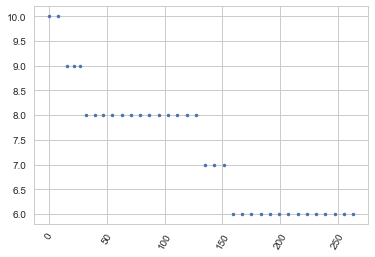

In [53]:
# results = Parallel(n_jobs=-1)(map(delayed(plot_images), purified_df.item_id.values[:10]))
# plt.style.use(['dark_background'])
# for result in results[2:5]:
for result in dummy_results:
#     fig = plt.figure()
    plt.plot(result.index, result.STOCK_AMOUNT, '.')
    plt.xticks(rotation='60')
#     plt.axis('off')
    plt.show()
#     plt.savefig('images/test/%idx.png'%idx)
#     plt.close(fig)

In [121]:
# target = results[36]
# # target = tmp_df
# # target = dummy_results[0]

# # 
# n_cluster, label = get_label_from_dbscan(target, eps=0.15, min_samples=3)
# target['label'] = label
# target = target[['STOCK_AMOUNT', 'label', 'REG_DT']]
# labels = target.label.unique()
# target = target.set_index('REG_DT')
# target = target.resample('1D').first()
# target['STOCK_AMOUNT_imputed'] = target['STOCK_AMOUNT']
# for label in labels:
#     idx = np.where(target.label.values == label)[0]
#     start_v = min(idx)
#     end_v = max(idx)
#     target['STOCK_AMOUNT_imputed'][start_v:end_v+1] = target['STOCK_AMOUNT'][start_v:end_v+1].interpolate(method='from_derivatives')
    
# df = target
# plt.subplot(2, 1, 1)
# plt.plot(df.index, df.STOCK_AMOUNT, ".")
# plt.xticks(rotation='60')
# plt.show()
# # df['STOCK_AMOUNT_imputed'][start_v:end_v+1] = target['STOCK_AMOUNT'][start_v:end_v+1].interpolate(method='from_derivatives')
# plt.subplot(2, 1, 2)
# plt.plot(df.index, df.STOCK_AMOUNT_imputed, ".")
# plt.xticks(rotation='60')
# plt.show()

In [199]:
# target['STOCK_AMOUNT_imputed'] = target.STOCK_AMOUNT_imputed.round()
# tmp = target
# tmp['weekday_name'] = tmp.index.dayofweek
# tmp['sell'] = np.append([0], np.negative(np.diff(tmp.STOCK_AMOUNT_imputed)))
# tmp['sell'][tmp['sell'].values < 0] = np.nan

# tmp.sell.astype(float)
# tmp['zscore'] = np.abs(tmp.sell - tmp.sell.mean() / tmp.sell.std())
# tmp['sell'][tmp['zscore'] > 3] = np.nan
# X_incomplete = tmp[['sell', 'weekday_name']].values

# try:
#     print('hi')
#     X_filled_knn = KNN(k=1).complete(X_incomplete)
#     print(X_filled_knn)
#     tmp['sell_impute'] = X_filled_knn[:,0]
# except:
#     tmp['sell_impute'] = tmp['sell']
# # plt.plot(tmp.index, tmp.sell)
# plt.plot(tmp.index, tmp.sell_impute)
# plt.xticks(rotation='60')
# plt.show()

In [ ]:
results = Parallel(n_jobs=-1)(map(delayed(get_ivt_item), purified_df.item_id.values))

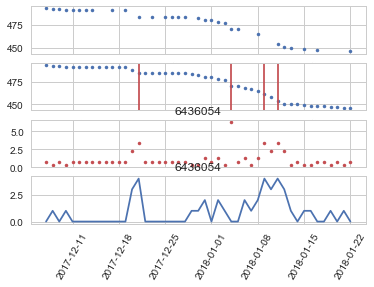

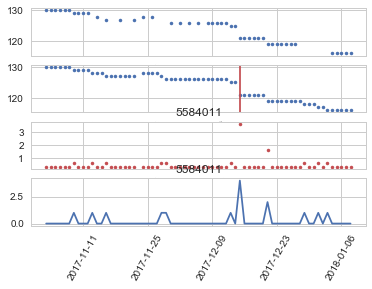

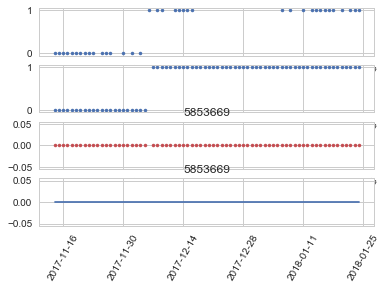

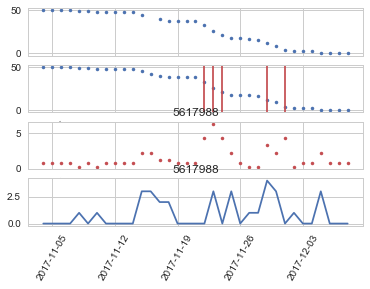

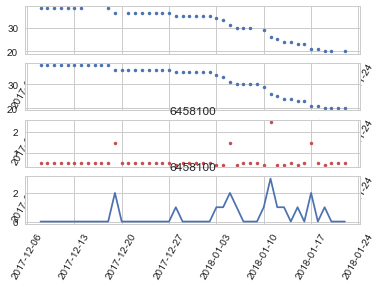

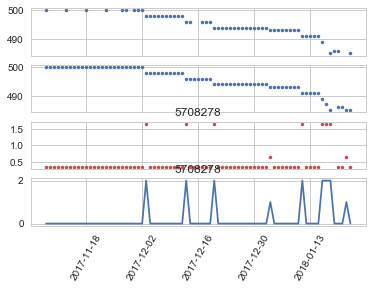

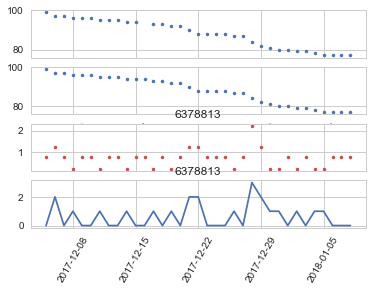

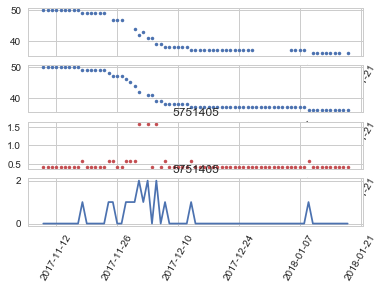

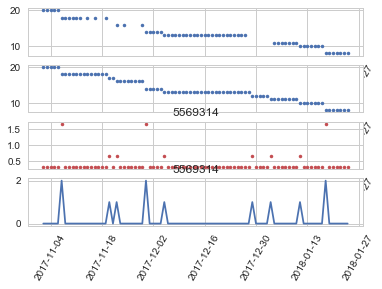

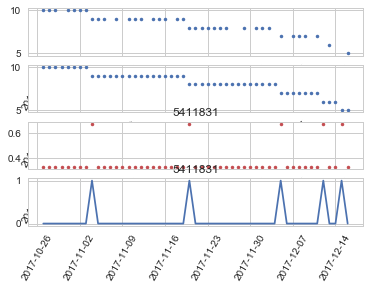

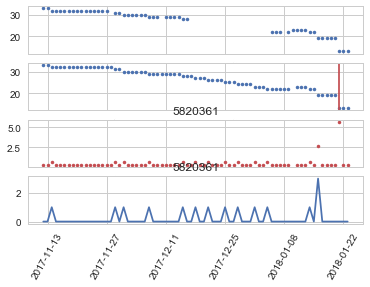

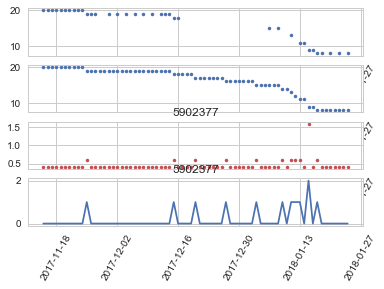

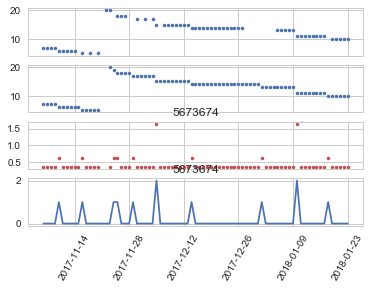

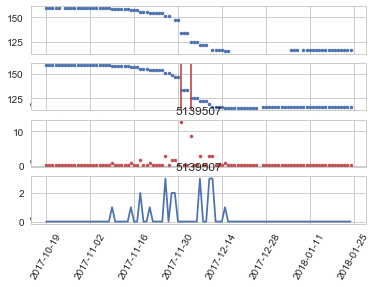

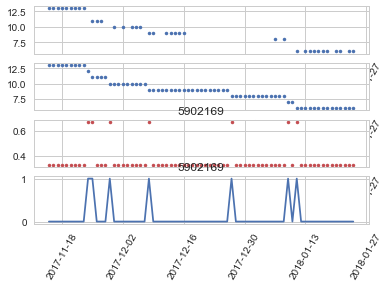

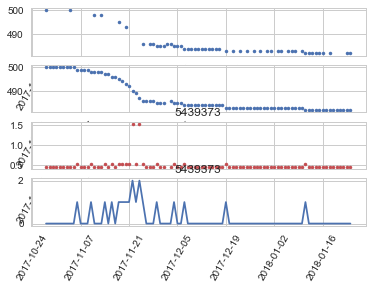

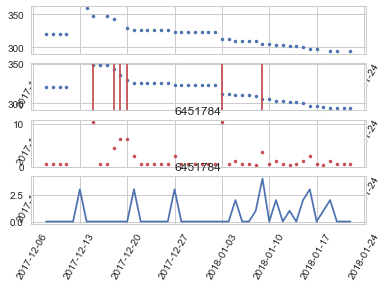

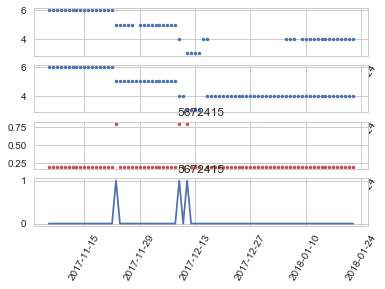

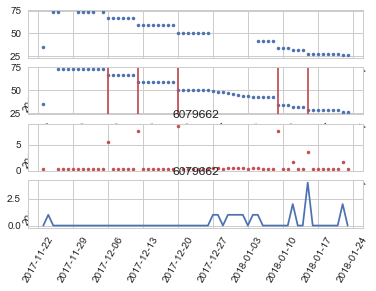

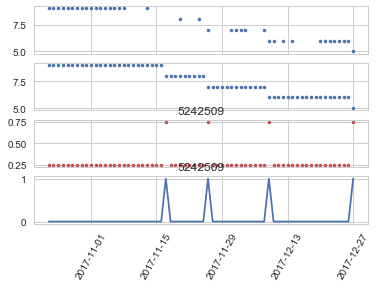

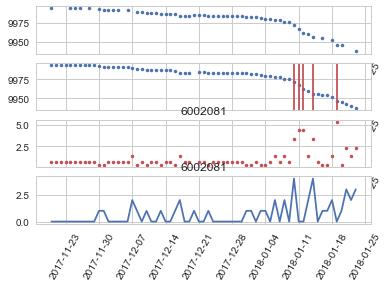

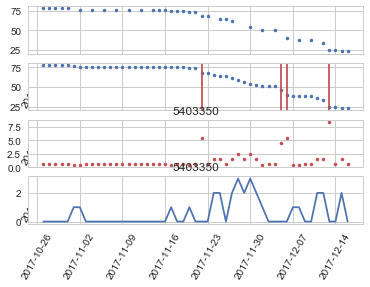

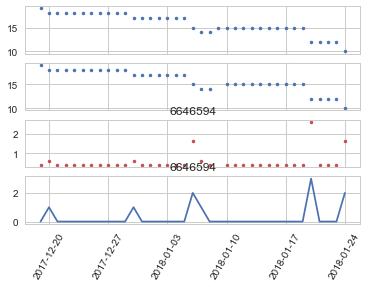

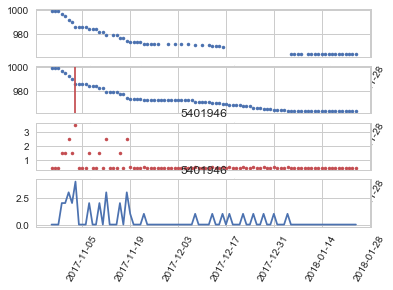

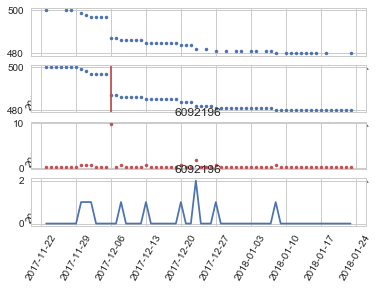

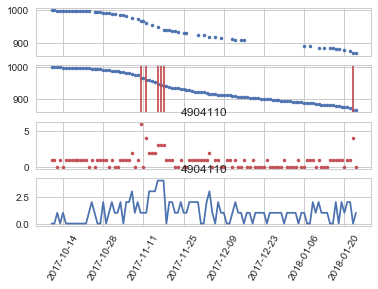

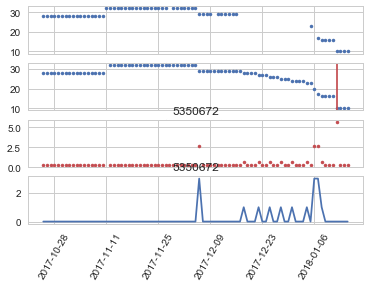

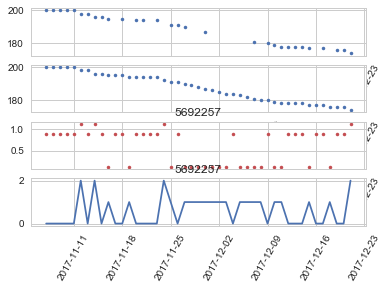

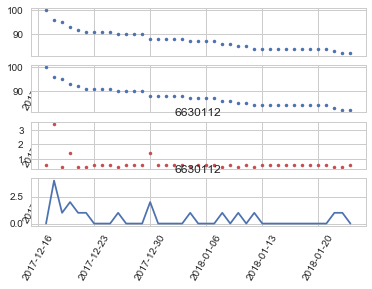

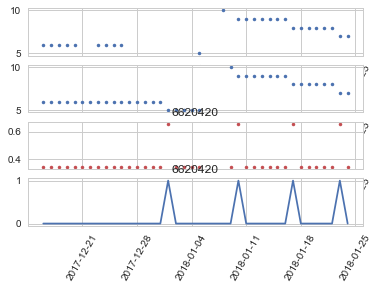

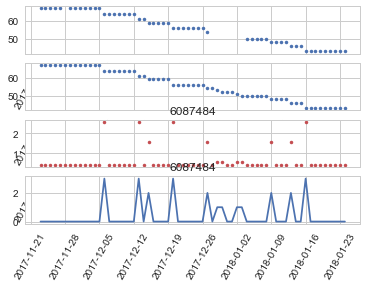

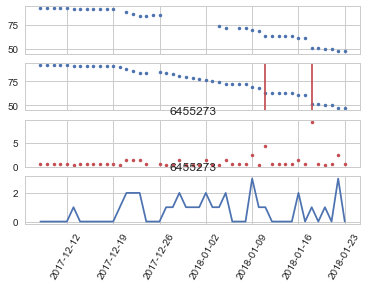

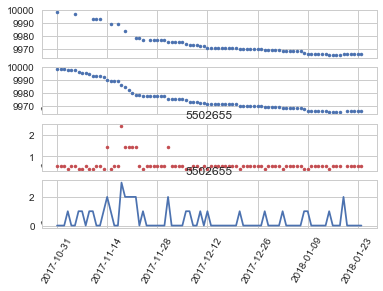

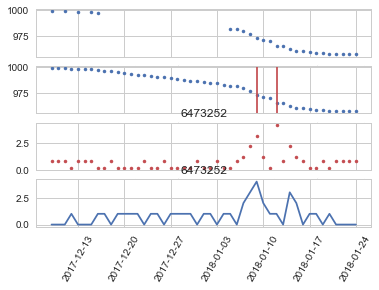

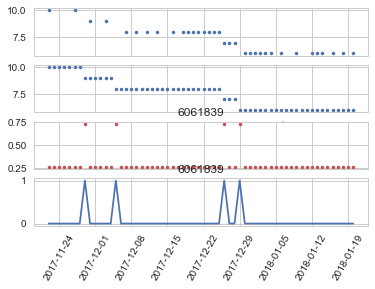

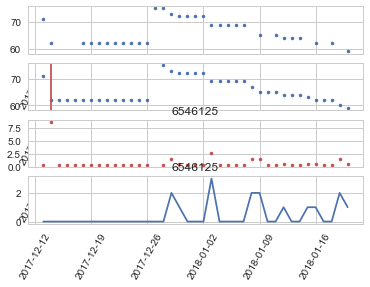

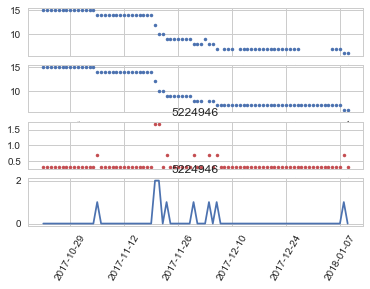

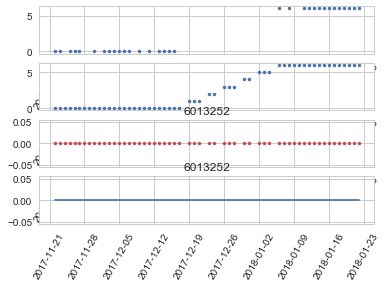

In [154]:
for result in results:
    target = clean_up_target_df(result)
    fig = plt.figure()
    plt.subplot(4, 1, 1)
    plt.plot(target.index, target.STOCK_AMOUNT, ".")
    plt.xticks(rotation='60')

    plt.subplot(4, 1, 2)
    plt.plot(target.index, target.STOCK_AMOUNT_imputed_trimed, ".")
    plt.xticks(rotation='60')
    
    if len(target.index[target.zscore > 3.5]) > 0:
        vlines = target.index[target.zscore > 3]
        for vline in vlines:
            plt.axvline(vline, c='r')

    plt.subplot(4, 1, 3)
    plt.plot(target.index, target.zscore, "r.",)
    plt.xticks(rotation='60')
    plt.title(str(result.ITEM_ID.values[0]))
    
    plt.subplot(4, 1, 4)
    plt.plot(target.index, target.sell_impute)
    plt.xticks(rotation='60')
    plt.title(str(result.ITEM_ID.values[0]))
#     plt.savefig("images/cleaned_images/cleaned_figure_%s" %result.ITEM_ID.values[0])
#     plt.close(fig)
    plt.show()

In [120]:
tmp_lst = []

engine = get_engine()

for result in results[:5]:

    item_id = result.ITEM_ID.values[0]
    get_sell_amount_by_item_id(item_id)['result'])
    result.columns = ['SELL_AMOUNT']
    result['ITEM_ID'] = item_id
    result['REG_ID'] = 'SERVER'
    result['UPT_DT'] = pd.to_datetime('now')
    result['COLLECT_DAY'] = pd.to_datetime('now')
    result['UPT_ID'] = 'FILTER ALGO'
    result.to_sql(con=engine, name='MWS_COLT_ITEM_SELL_AMT', if_exists='append', flavor='mysql')

In [131]:
import glob
item = glob.glob('data/pickle/ivt_item/ivt_item_1.pkl')
tmpp_df = pd.read_pickle(item[0])

In [144]:
list(tmpp_df.groupby('ITEM_ID'))[:2]

[(5550141,
               ID  ITEM_ID              STOCK_ID COLOR_OPTION SIZE_OPTION STYLE_OPTION GIFT_OPTION   OPTION  STOCK_AMOUNT  ADD_PRICE COLLECT_DAY  REG_ID              REG_DT
  0    1442958435  5550141  -6350997671342987296           레드          55         None        None  레드 x 55             5          0    20171102  SERVER 2017-11-02 02:52:43
  1    1442958436  5550141  -6350997671342987038           레드          66         None        None  레드 x 66             2          0    20171102  SERVER 2017-11-02 02:52:43
  2    1442958437  5550141  -5904175963728729687           블랙          55         None        None  블랙 x 55            12          0    20171102  SERVER 2017-11-02 02:52:43
  3    1442958438  5550141  -5904175963728729429           블랙          66         None        None  블랙 x 66             2          0    20171102  SERVER 2017-11-02 02:52:43
  4    1442958439  5550141  -6350997671342986780           레드          77         None        None  레드 x 77             0   

In [146]:
# pd.concat([results[0], results[1]])